# Evictions in LA 2023

## Import

In [2]:
import pandas as pd
import geopandas as gpd 
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import KNN
import esda
from esda.moran import Moran
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal 
import seaborn as sns
import contextily
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.formula.api import glm
from patsy import dmatrices
from pygris import tracts
import bambi as bmb
import arviz as az


In [3]:

evictions = pd.read_csv('data/2023_eviction_filings_final.csv')
evictions_geocoded = pd.read_csv('data/evictions_geocoded.csv')
svi_la = pd.read_csv('data/SVI_la.csv',dtype={'FIPS':str})
rent_df = pd.read_csv('data/ACSST5Y2020.S2502-Data.csv',dtype={'FIPS':str})


In [4]:

gdf_ct = tracts(state='California',county='Los Angeles')

Using the default year of 2021
Using FIPS code '06' for input 'California'
Using FIPS code '037' for input 'Los Angeles'


## Cleaning

In [5]:

# Convert evictions 'Address' to string
evictions['Address'] = evictions['Address'].astype(str)

# Create new column in evictions_geocode with matching name 'Address' and make sure it's a string
evictions_geocoded['Address'] = evictions_geocoded['input_string'].astype(str)
evictions_geocoded = gpd.GeoDataFrame(evictions_geocoded,geometry=gpd.points_from_xy(evictions_geocoded['longitude'],evictions_geocoded['latitude']),crs='4326')
evics = evictions_geocoded.merge(evictions,left_index=True,right_index=True)
evics = evics.to_crs(epsg='3857')




In [6]:
rent_df = rent_df[['FIPS','S2502_C05_001E']]
rent_df = rent_df.rename(columns={'S2502_C05_001E':'renter_occupied'})

In [7]:
gdf_ct.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
223,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"POLYGON ((-118.65862 34.17142, -118.65849 34.1..."
415,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"POLYGON ((-118.21630 33.90339, -118.21538 33.9..."
416,06,037,541801,06037541801,5418.01,Census Tract 5418.01,G5020,S,714942,0,+33.9118044,-118.1946754,"POLYGON ((-118.19998 33.90668, -118.19878 33.9..."
427,06,037,541802,06037541802,5418.02,Census Tract 5418.02,G5020,S,1110125,0,+33.9098797,-118.1866746,"POLYGON ((-118.19359 33.90654, -118.19343 33.9..."
428,06,037,542000,06037542000,5420,Census Tract 5420,G5020,S,974029,0,+33.9055708,-118.2031580,"POLYGON ((-118.20734 33.90732, -118.20733 33.9..."


In [8]:
svi_la = svi_la[svi_la['COUNTY'] == 'Los Angeles']

<Axes: >

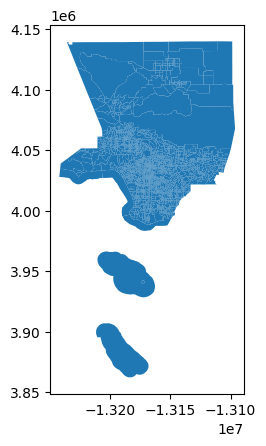

In [9]:
gdf_ct = gdf_ct.to_crs(epsg='3857')

# trim the data to the bare minimum columns
gdf_ct = gdf_ct[['GEOID','geometry']]

# rename the columns
gdf_ct.columns = ['FIPS','geometry']
# last rows
gdf_ct.plot()



In [10]:
svi_la['FIPS'].isin(gdf_ct['FIPS'])

1378    True
1379    True
1380    True
1381    True
1382    True
        ... 
3868    True
3869    True
3870    True
3871    True
3872    True
Name: FIPS, Length: 2495, dtype: bool

### Process and merge dataframes

In [11]:
# Merge tract geo data with social vulnerability index data
gdf_ct = gdf_ct.merge(svi_la,on='FIPS')

# Select and rename columns
gdf_ct = gdf_ct.loc[:, ['FIPS','E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150', 'EP_UNEMP','EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'geometry']]
gdf_ct = gdf_ct.rename(
    columns={'E_TOTPOP':'total_pop','E_HU':'housing_units','E_HH':'households','EP_POV150':'pov_below150','EP_UNEMP':'unemployed','EP_PCI':'cost_burdened_low_income','EP_NOHSDP':'no_high_school','EP_AGE65':'persons_over65','EP_AGE17':'persons_under17','EP_DISABL':'disabled_pop','EP_SNGPNT':'single_parent','EP_MINRTY':'minority_pop','EP_LIMENG':'limited_eng','EP_MUNIT':'10_units_plus','EP_MOBILE':'mobile_homes','EP_CROWD':'crowded_units','EP_NOVEH':'no_vehicle','EP_GROUPQ':'persons_group_quarters'
})

# Join cleaned up dataset with evictions using spatial join. Also create a new column of 'evictions_count' to count per tract
join = gdf_ct.sjoin(evics)
evics_ct = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='evictions_count')
gdf_ct=gdf_ct.merge(evics_ct,on='FIPS')

# Merge our dataframe with dataset containing total number of rental units per census tract
gdf_ct = gdf_ct.merge(rent_df,on='FIPS')

# Remove tracts without rental units and scale by 1000 
gdf_ct = gdf_ct[gdf_ct['renter_occupied']>0]
gdf_ct['count_norm'] = gdf_ct['evictions_count'] / gdf_ct['renter_occupied'] * 100
gdf_ct

,FIPS,total_pop,housing_units,households,pov_below150,unemployed,no_high_school,persons_over65,persons_under17,disabled_pop,...,limited_eng,10_units_plus,mobile_homes,crowded_units,no_vehicle,persons_group_quarters,geometry,evictions_count,renter_occupied,count_norm
0,06037137000,5184,1842,1783,8.6,8.4,4.2,25.8,19.3,16.2,...,4.1,3.6,4.5,0.5,1.4,0.7,"POLYGON ((-13209017.143 4051842.716, -13209002...",5,341,1.466276
1,06037541605,5069,1456,1404,37.7,8.6,45.6,10.0,20.0,11.7,...,17.5,2.3,5.1,19.3,4.5,0.7,"POLYGON ((-13159778.130 4015837.180, -13159675...",2,780,0.256410
2,06037503301,3560,1056,1011,8.8,4.3,5.0,14.3,22.8,8.1,...,1.2,0.0,0.0,1.5,4.5,0.0,"POLYGON ((-13138507.795 4021922.004, -13138448...",1,136,0.735294
3,06037542601,3539,810,757,42.9,5.8,44.1,5.8,31.1,7.7,...,21.4,19.9,4.1,37.6,7.3,0.1,"POLYGON ((-13161585.396 4016309.952, -13161523...",11,543,2.025783
4,06037609900,2015,670,644,25.1,5.5,20.6,25.2,18.7,15.0,...,8.3,5.7,0.0,6.4,7.1,12.8,"POLYGON ((-13170113.632 3993675.719, -13170113...",1,325,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,06037980015,993,476,444,46.5,10.5,22.9,3.0,24.8,9.7,...,7.1,70.4,0.0,13.7,2.9,3.3,"POLYGON ((-13170262.236 3997538.860, -13170234...",70,444,15.765766
1154,06037262601,3478,1363,1290,2.6,4.0,4.1,21.6,23.1,3.7,...,1.0,1.2,1.2,1.2,0.5,0.0,"POLYGON ((-13199770.798 4039574.959, -13199705...",9,115,7.826087
1155,06037189600,3825,2296,1985,18.9,4.6,5.4,8.4,10.4,6.2,...,3.3,45.8,0.0,3.1,7.3,0.8,"POLYGON ((-13173212.577 4043362.613, -13173207...",78,1278,6.103286
1156,06037189400,3145,2039,1531,6.4,7.5,0.8,12.1,16.6,3.5,...,0.7,5.6,0.0,0.0,2.7,0.5,"POLYGON ((-13172074.771 4043732.876, -13172072...",15,658,2.279635


### Preliminary visualization of outcome variable

In [12]:
gdf_ct.columns.to_list()

['FIPS',
 'total_pop',
 'housing_units',
 'households',
 'pov_below150',
 'unemployed',
 'no_high_school',
 'persons_over65',
 'persons_under17',
 'disabled_pop',
 'single_parent',
 'minority_pop',
 'limited_eng',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'no_vehicle',
 'persons_group_quarters',
 'geometry',
 'evictions_count',
 'renter_occupied',
 'count_norm']

Non parametric testing because of difference in mean and median

## Data Exploration

In [13]:
gdf_ct['count_norm'].describe()

count    1153.000000
mean        7.819917
std        14.221013
min         0.046490
25%         1.872659
50%         3.571429
75%         7.761733
max       237.288136
Name: count_norm, dtype: float64

### Scale data using a min max scaler

In [14]:
census_vars = [
 'pov_below150',
 'unemployed',
 'no_high_school',
 'minority_pop',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'renter_occupied',
 'count_norm'
]

In [15]:
scaler = MinMaxScaler()
std_scaler = StandardScaler()
gdf_ct[census_vars] = std_scaler.fit_transform(gdf_ct[census_vars])


In [17]:
table = gdf_ct.describe()
table

,total_pop,housing_units,households,pov_below150,unemployed,no_high_school,persons_over65,persons_under17,disabled_pop,single_parent,minority_pop,limited_eng,10_units_plus,mobile_homes,crowded_units,no_vehicle,persons_group_quarters,evictions_count,renter_occupied,count_norm
count,1153.000000,1153.000000,1153.000000,1.153000e+03,1.153000e+03,1.153000e+03,1153.000000,1153.000000,1153.000000,1153.000000,1.153000e+03,1153.000000,1.153000e+03,1.153000e+03,1.153000e+03,1153.000000,1153.000000,1153.000000,1.153000e+03,1.153000e+03
mean,3662.051171,1401.480486,1298.594970,-1.756329e-16,-1.009119e-16,8.935707e-17,13.113183,19.734866,10.468690,6.452472,8.627579e-17,14.053252,3.081278e-17,-4.313789e-17,1.540639e-17,12.072593,1.929141,66.535126,9.860090e-17,-1.848767e-17
std,1199.835510,532.677917,478.372931,1.000434e+00,1.000434e+00,1.000434e+00,6.363670,7.935086,4.716979,5.840064,1.000434e+00,10.920300,1.000434e+00,1.000434e+00,1.000434e+00,11.137864,7.844901,130.264977,1.000434e+00,1.000434e+00
min,65.000000,17.000000,17.000000,-1.705137e+00,-1.675347e+00,-1.324543e+00,0.000000,0.000000,0.000000,0.000000,-2.476573e+00,0.000000,-1.171616e+00,-2.601098e-01,-1.185240e+00,0.000000,0.000000,1.000000,-1.735274e+00,-5.468528e-01
25%,2809.000000,1043.000000,972.000000,-8.096688e-01,-6.149139e-01,-9.078512e-01,8.600000,14.700000,7.700000,2.400000,-8.465428e-01,4.400000,-8.754165e-01,-2.601098e-01,-8.489978e-01,4.500000,0.000000,10.000000,-6.962639e-01,-4.183836e-01
50%,3532.000000,1338.000000,1248.000000,-1.618831e-01,-1.328990e-01,-1.518541e-01,12.200000,19.800000,9.800000,5.200000,2.948604e-01,12.300000,-2.426257e-01,-2.601098e-01,-2.269491e-01,9.100000,0.200000,26.000000,-1.065552e-01,-2.988769e-01
75%,4445.000000,1679.000000,1544.000000,7.018312e-01,3.973174e-01,8.303469e-01,16.700000,25.100000,12.500000,8.900000,9.247317e-01,21.500000,7.267560e-01,-2.601098e-01,6.893118e-01,16.200000,1.000000,65.000000,6.041194e-01,-4.093220e-03
max,9559.000000,4733.000000,4424.000000,4.302758e+00,8.832578e+00,3.044764e+00,53.200000,50.800000,60.800000,81.800000,1.119419e+00,63.100000,2.194292e+00,1.061168e+01,4.295513e+00,86.400000,96.400000,1554.000000,6.762579e+00,1.614286e+01


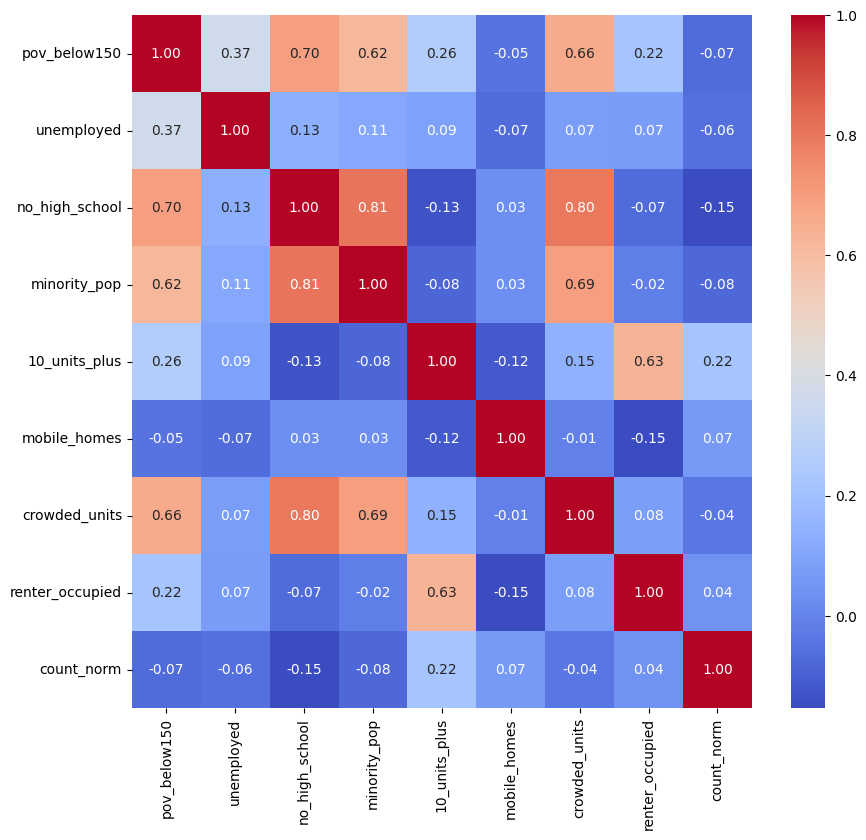

In [18]:

corr = gdf_ct[census_vars].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

### Calculate variance inflation factor for each variable considering high collinearity based on data exploration

In [19]:
C = add_constant(gdf_ct[census_vars])

vif = pd.Series([variance_inflation_factor(C.values,i) for i in range(C.shape[1])],index=C.columns)
vif

const              1.000000
pov_below150       3.159825
unemployed         1.240460
no_high_school     5.799339
minority_pop       3.015598
10_units_plus      2.332561
mobile_homes       1.036801
crowded_units      3.512796
renter_occupied    1.724691
count_norm         1.104576
dtype: float64

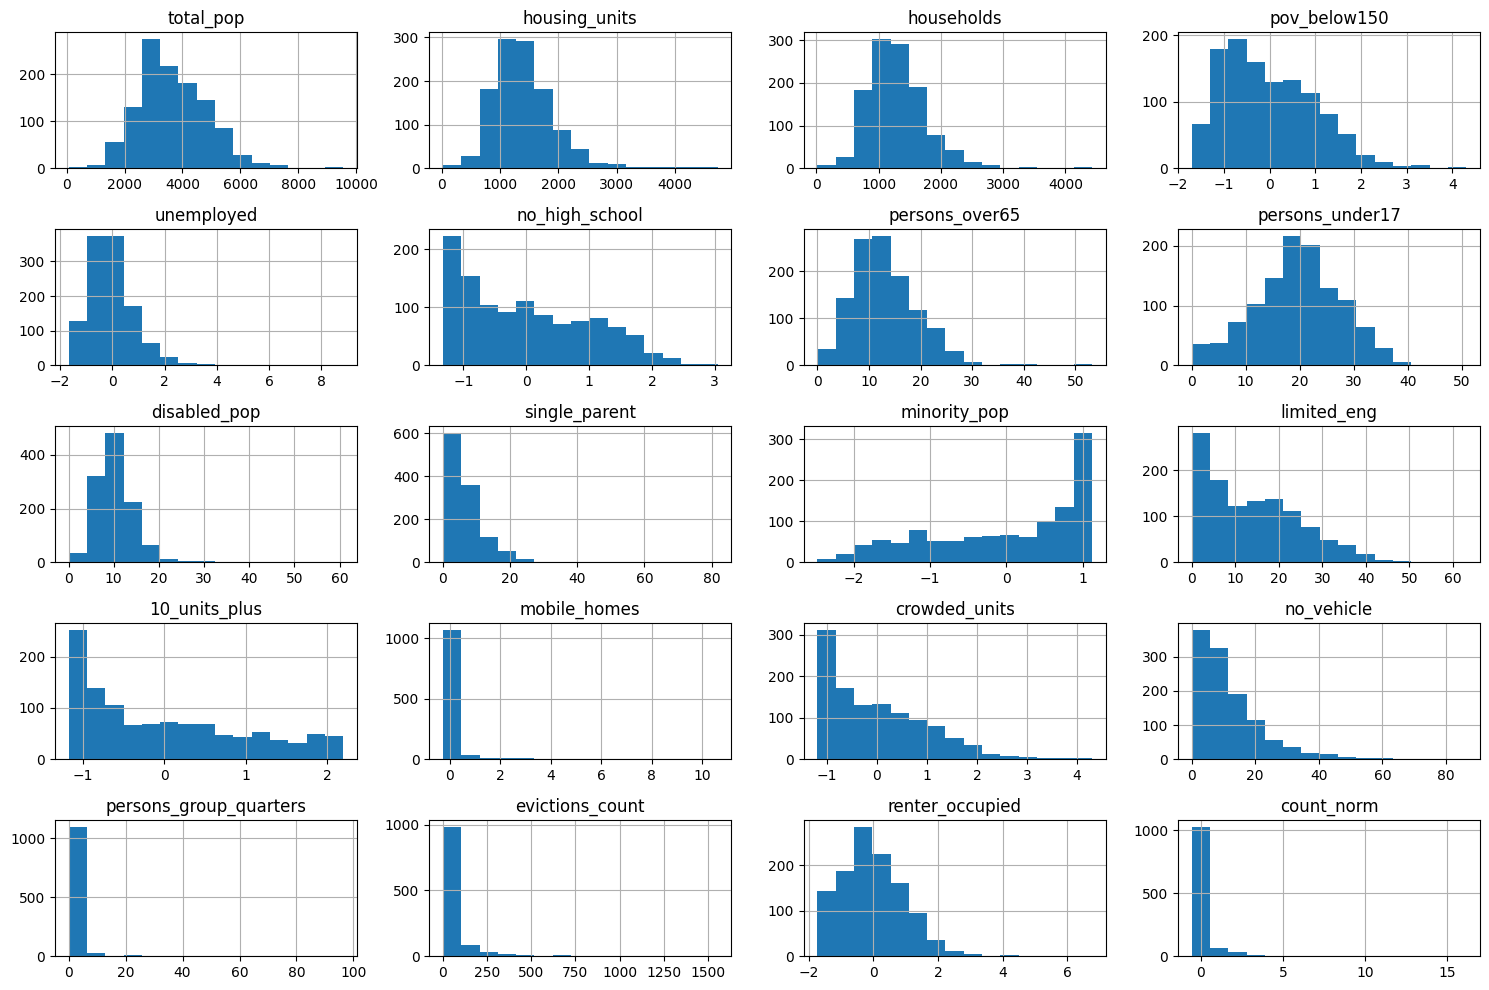

In [20]:
gdf_ct.hist(bins=15,figsize=(15,10))
plt.tight_layout()
plt.show()

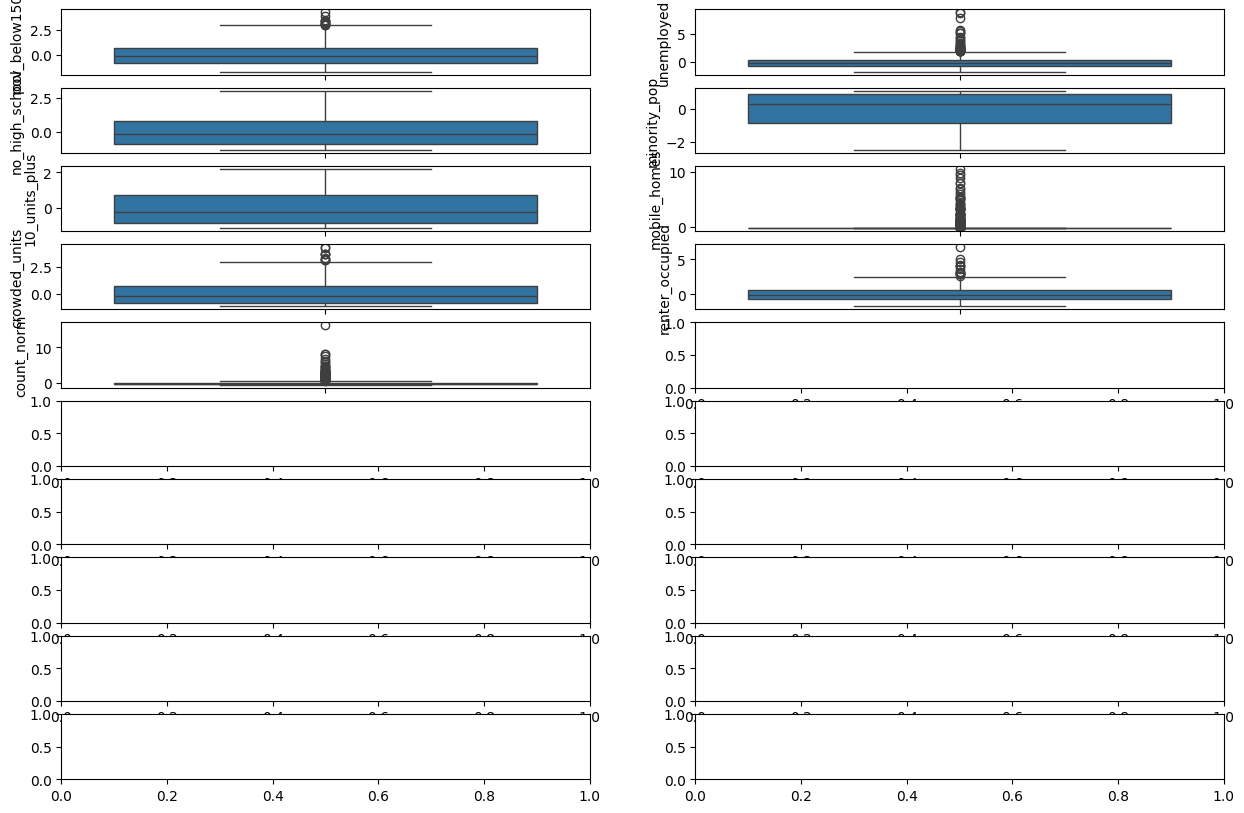

In [21]:
fig, ax = plt.subplots(10,2,figsize=(15,10))
ax = ax.flatten()

for i, var in enumerate(gdf_ct[census_vars]):
    sns.boxplot(y=var,data=gdf_ct,ax=ax[i])
   
plt.show()

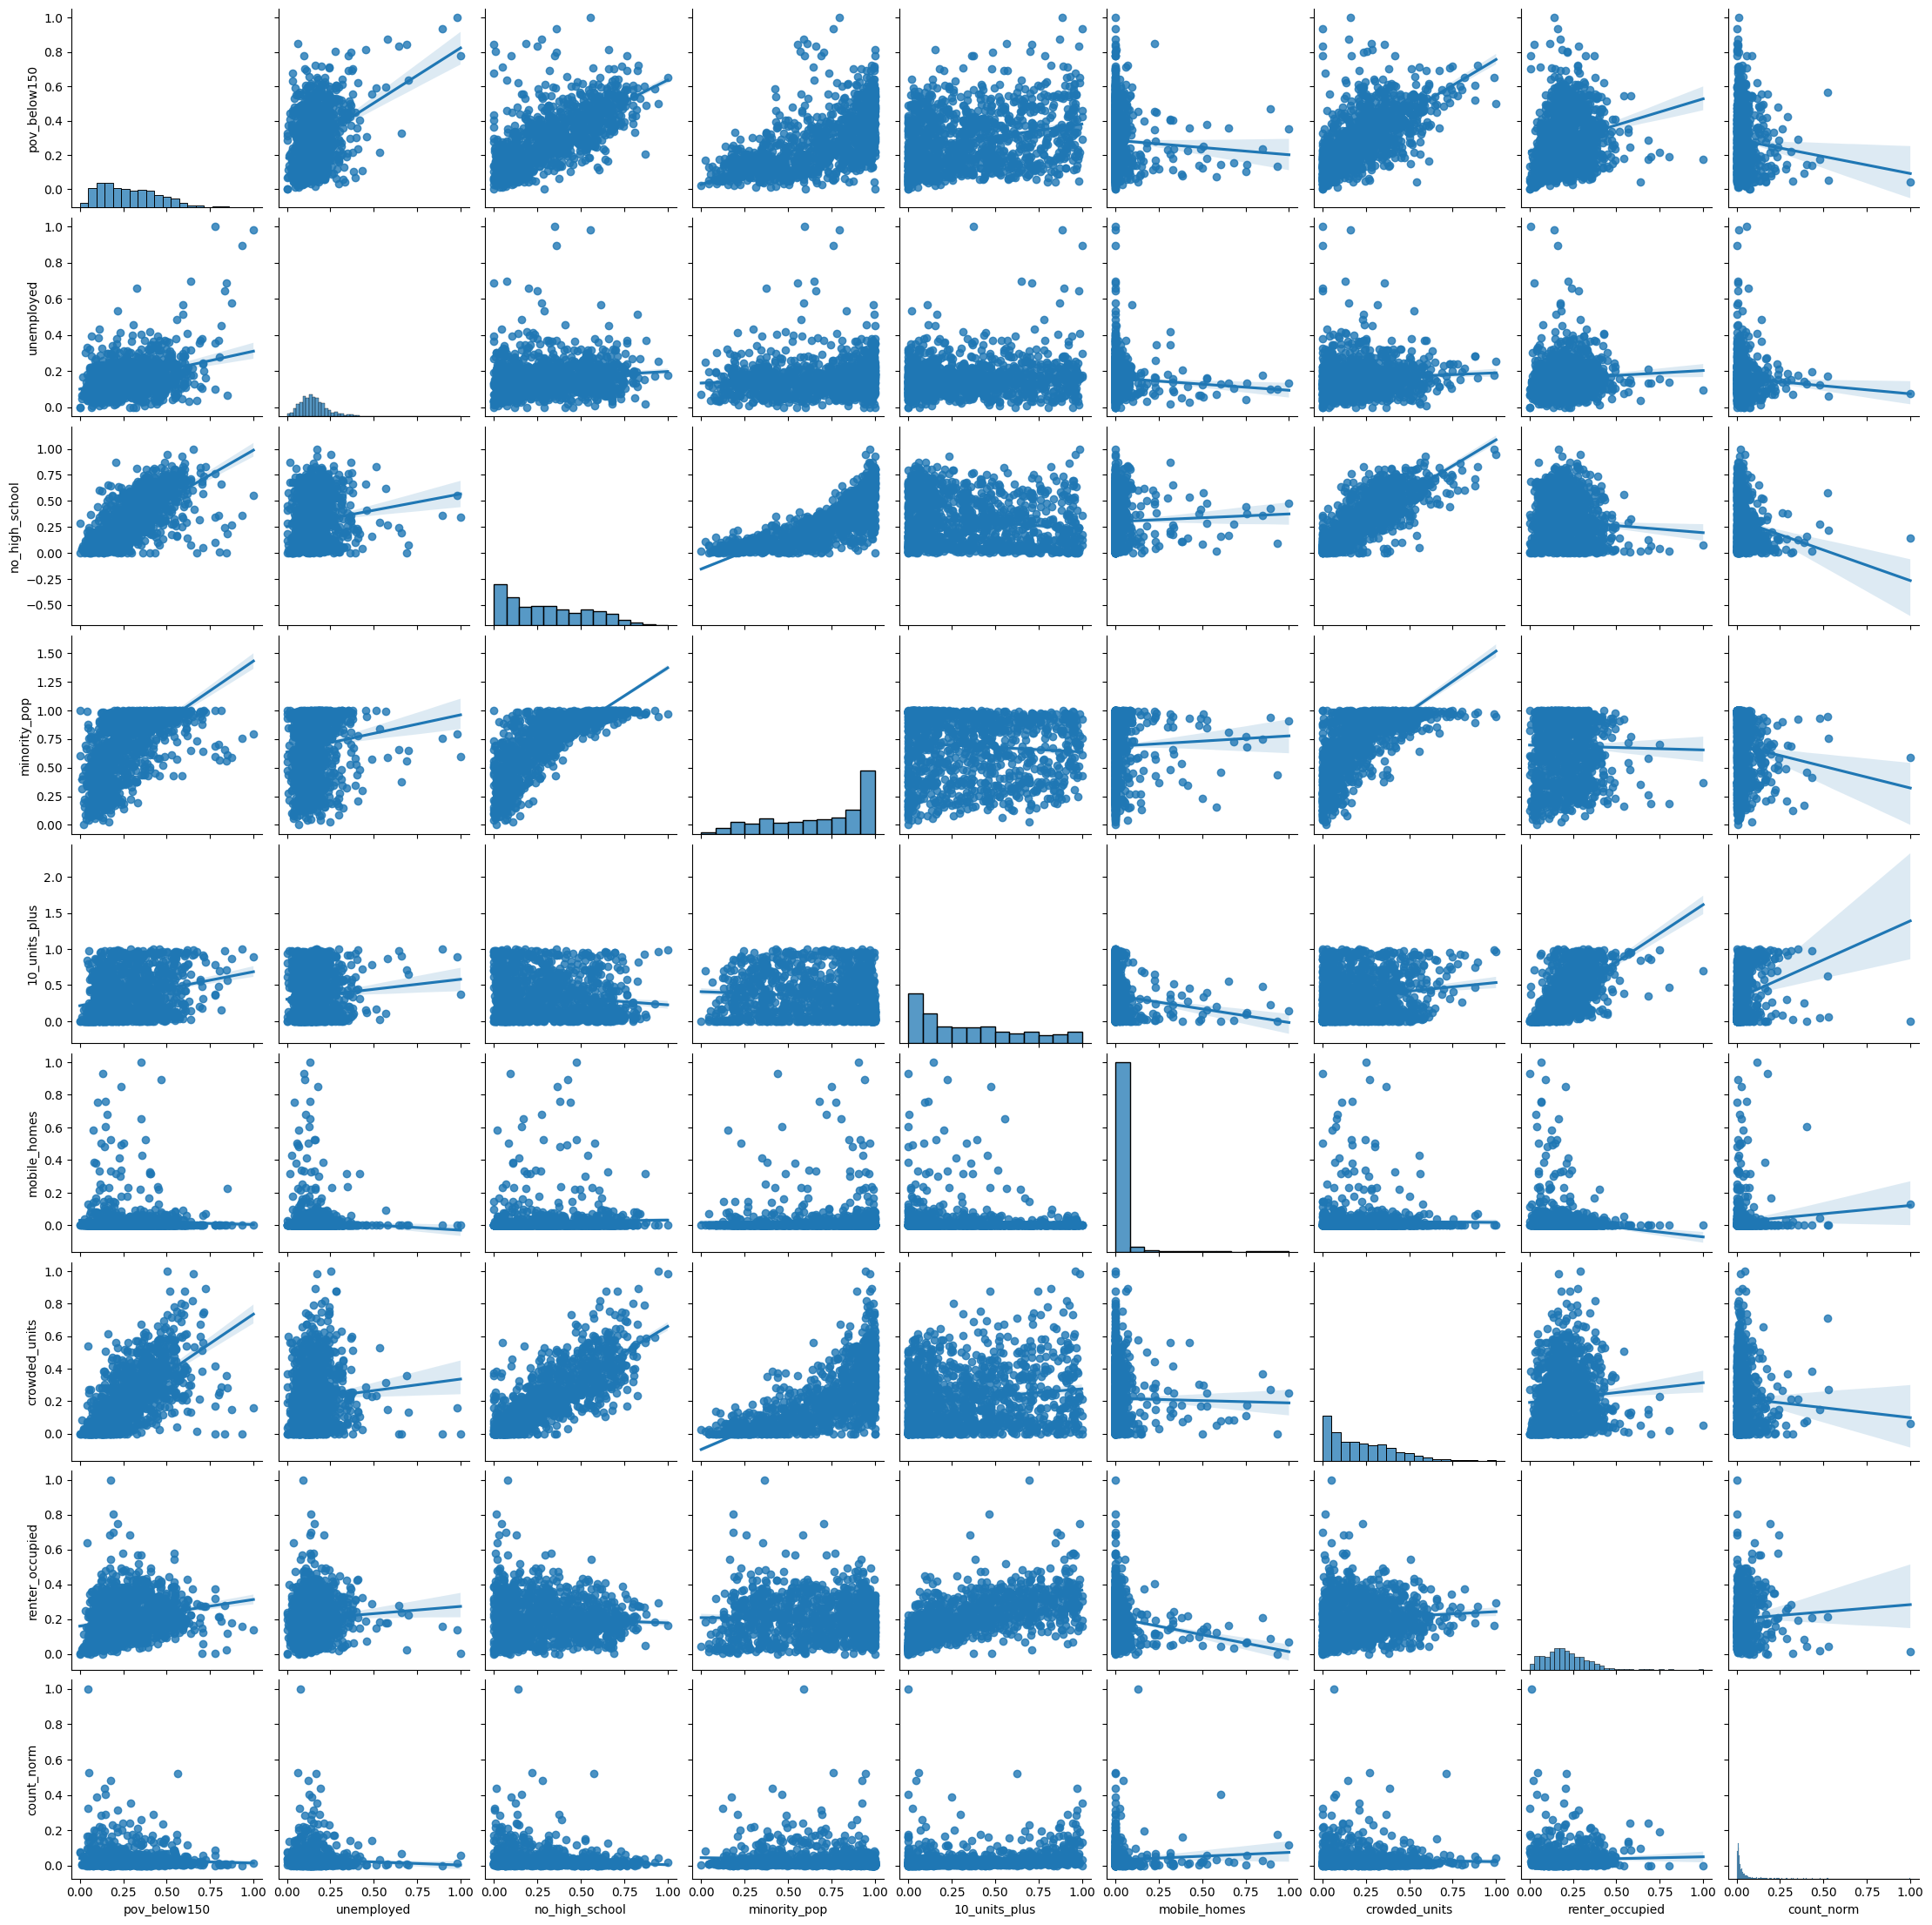

In [50]:
sns.pairplot(gdf_ct[census_vars],kind='reg')
plt.show()

In [51]:
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "evictions"
          ],
          "id": "sreoedtdg",
          "name": [
            "Notice Date"
          ],
          "type": "timeRange",
          "value": [
            1598918400000,
            1601078400000
          ],
          "enlarged": True,
          "plotType": "histogram",
          "yAxis": None
        }
      ],
      "layers": [
        {
          "id": "y8t676q",
          "type": "grid",
          "config": {
            "dataId": "evictions",
            "label": "Point",
            "color": [
              34,
              63,
              154
            ],
            "columns": {
              "lat": "latitude",
              "lng": "longitude"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "worldUnitSize": 0.5,
              "colorRange": {
                "name": "ColorBrewer RdYlGn-6",
                "type": "diverging",
                "category": "ColorBrewer",
                "colors": [
                  "#1a9850",
                  "#91cf60",
                  "#d9ef8b",
                  "#fee08b",
                  "#fc8d59",
                  "#d73027"
                ],
                "reversed": True
              },
              "coverage": 1,
              "sizeRange": [
                0,
                500
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 20.9,
              "colorAggregation": "count",
              "sizeAggregation": "count",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantize",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "evictions": [
              {
                "name": "Notice Date",
                "format": None
              },
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 24,
      "dragRotate": True,
      "latitude": 33.837184166330836,
      "longitude": -118.46478962372794,
      "pitch": 50,
      "zoom": 9,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [52]:
from keplergl import KeplerGl
map = KeplerGl(height=600, width=800, data={'evictions':evics},config=config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['evictions'], 'id': 'sreoedt…

### Summary of exploration

So it looks as though the data is not normally distributed across multiple variables and several variables have high degrees of multicollinearity. The low numbers of mobile homes and group quarters also seem to skew the data. I'm not entirely sure how to address these but will return to this. 

## COVID Rent Protections and timeline of evictions

In [53]:
# Convert notice date to datetime format
evics['notice_date_dt'] = pd.to_datetime(evics['Notice Date'], format='%m/%d/%y')

# Make sure there aren't any from outside 2023
evics = evics[evics['notice_date_dt'].dt.year >= 2023 ]

# Create a dataframe to hold eviction counts per day
address_count_grpd = evics.value_counts(['notice_date_dt']).reset_index(name='count')
address_count_grpd


/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,notice_date_dt,count
0,2023-03-08,1666
1,2023-04-05,1640
2,2023-04-06,1549
3,2023-05-04,1494
4,2023-04-07,1448
...,...,...
341,2023-12-25,1
342,2023-01-09,1
343,2023-01-08,1
344,2023-01-06,1


### Timeline of evictions for 2023

In [54]:
fig_date_year = px.bar(
    address_count_grpd,
    x = 'notice_date_dt',
    y='count',
    text='count',
    labels={
        'notice_date_dt':'Notice Date',
        'count':'Count'
    },
    title='Eviction filings in 2023',
    
)
fig_date_year.add_annotation(x='2023-04-01', y=0,
            text="End of COVID Rent Protections",
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-200,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.8)
fig_date_year.show()

## Spatial Analysis

### Calculate spatial weights

In [55]:
# Generate W from the GeoDataFrame
w = KNN.from_dataframe(gdf_ct,geom_col='geometry',k=8)
# Row-standardization
w.transform = "R"
gdf_ct["w_count"] = libpysal.weights.lag_spatial(w, gdf_ct['count_norm'])

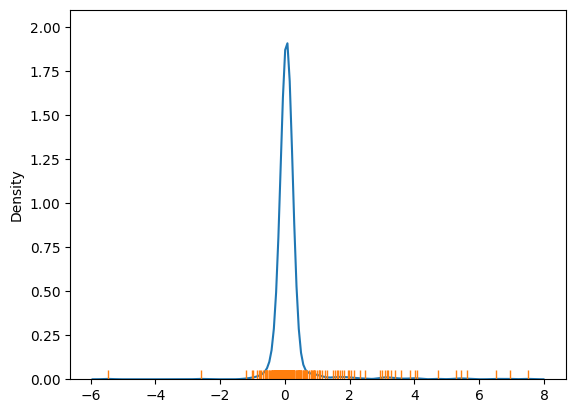

In [56]:
lisa = esda.moran.Moran_Local(gdf_ct['count_norm'], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

### Create moran scatterplot

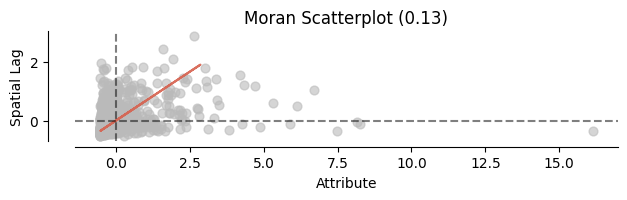

In [57]:
# Set y to list of normalized eviction count
y = gdf_ct['count_norm']

# Initialize moran plot and then graph
moran = Moran(y,w)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Plot Reference Distribution

/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.13', ylabel='Density'>)

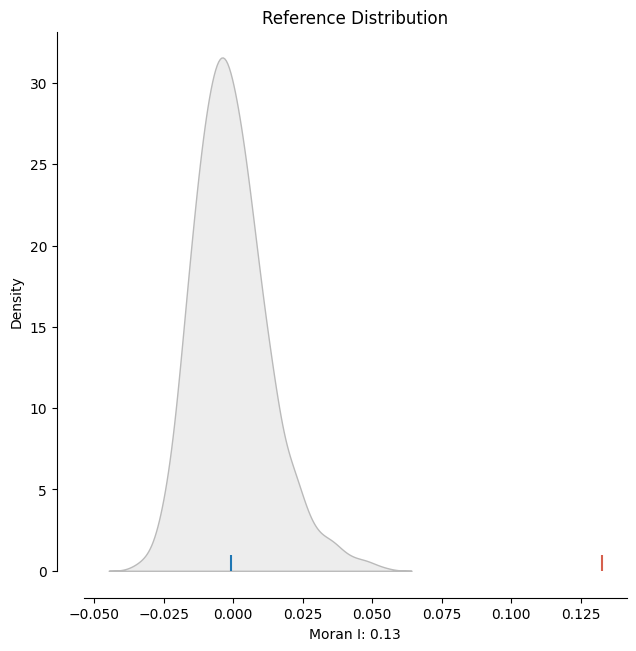

In [58]:
plot_moran_simulation(moran,aspect_equal=False)

### Visualize weighted count vs original, normalized count

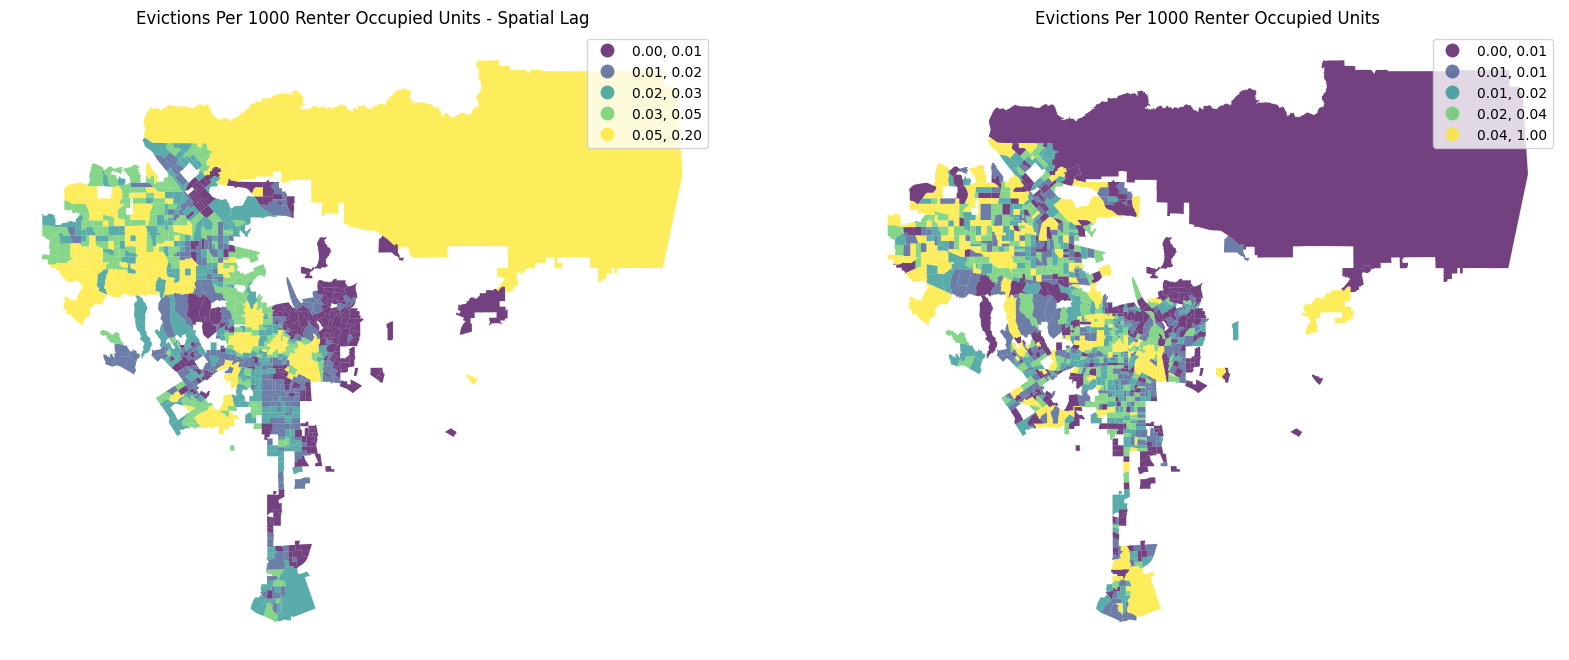

In [59]:
f, axs = plt.subplots(1,2,figsize=(20, 16))
ax1, ax2 = axs

gdf_ct.plot(
    column="w_count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)

gdf_ct.plot(
    column="count_norm",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)

ax1.axis('off')
ax2.axis('off')
ax1.set_title('Evictions Per 1000 Renter Occupied Units - Spatial Lag')
ax2.set_title('Evictions Per 1000 Renter Occupied Units')
plt.show()

### Calculate local moran values, plot values, and visualize clusters

In [60]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, w)

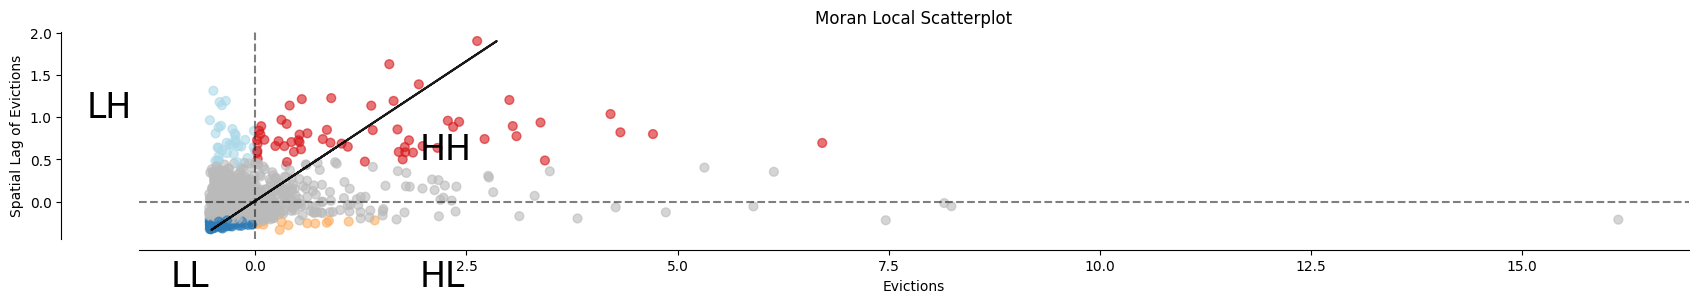

In [61]:
# Plot
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Evictions")
ax.set_ylabel('Spatial Lag of Evictions')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

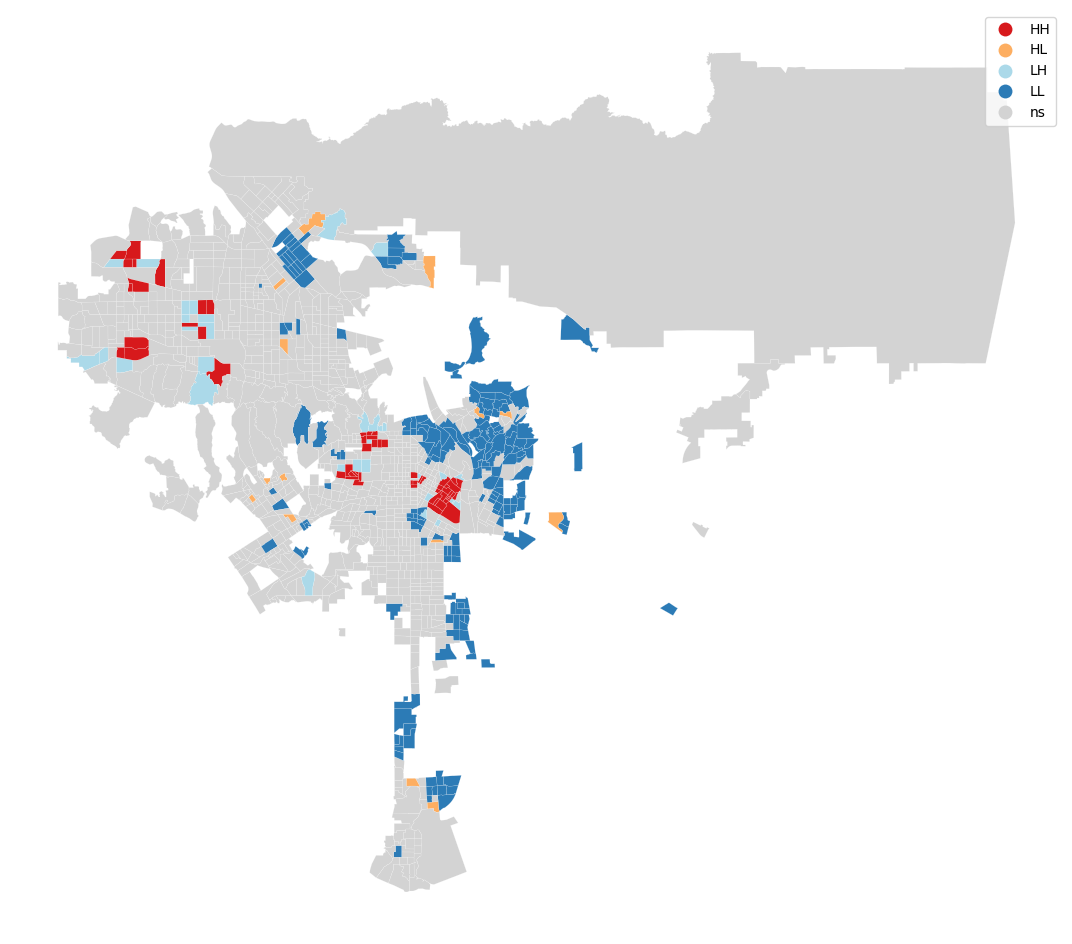

In [62]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax)
plt.show()

And create a map comparing different p-values

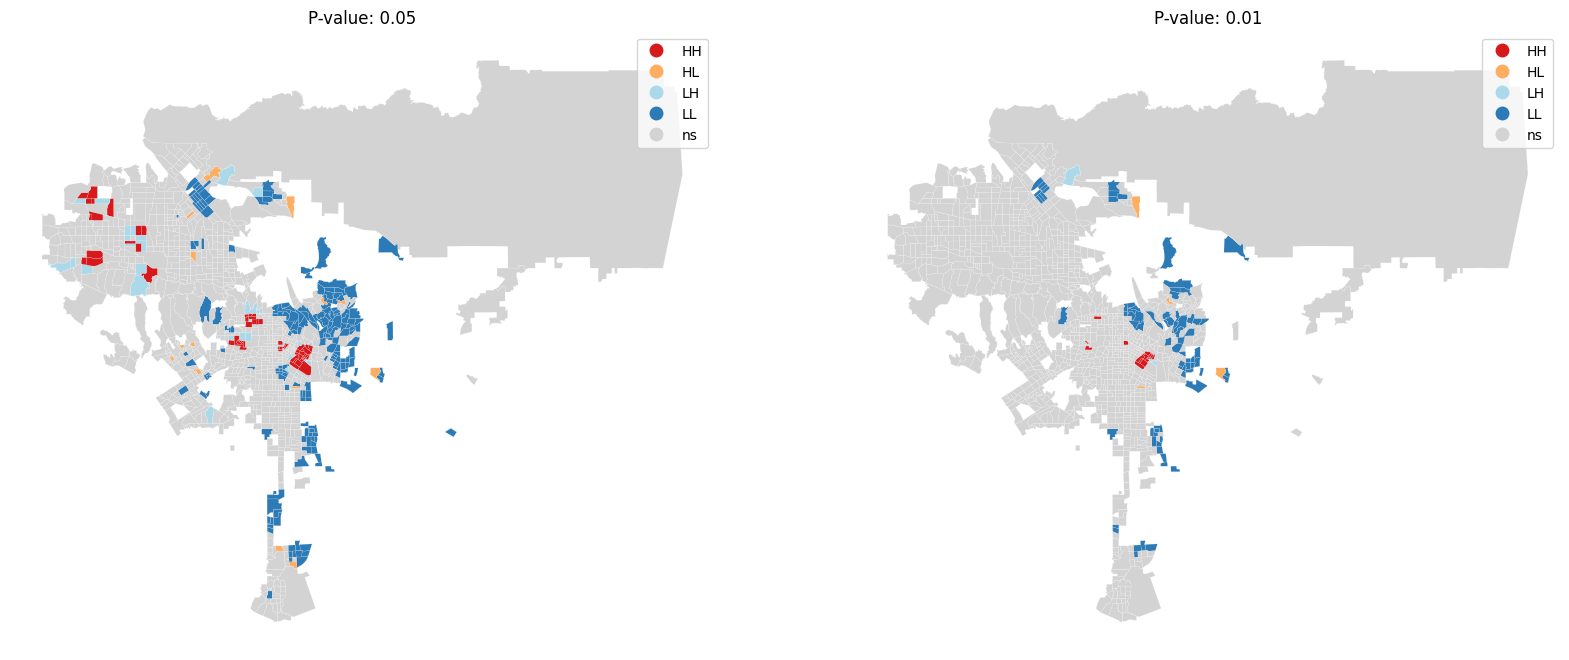

In [63]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf_ct, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

/var/folders/6m/h91b_7rn0556n1htz41z92g00000gn/T/ipykernel_96799/586694209.py:8: FutureWarning:

'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)



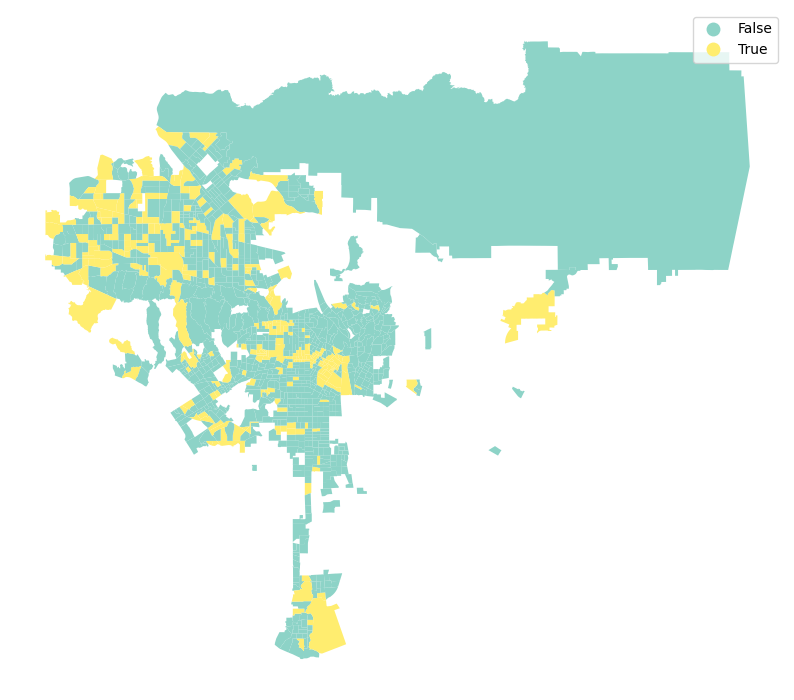

In [64]:
# Create a binary variable to subset 'high' eviction rate tracts and 'low' eviction rate tracts
evic_mean = gdf_ct['count_norm'].mean()
gdf_ct['evic_risk'] = gdf_ct['count_norm']>evic_mean

# Visualize the new variable
f, ax = plt.subplots(1,figsize=(10,10))

gdf_ct.plot(
    ax=ax,
    column='evic_risk',
    categorical=True,
    legend=True,
    colormap='Set3',
)
ax.set_axis_off()
plt.show()

In [65]:
# Transform
w.transform = "O"
jc = esda.join_counts.Join_Counts(gdf_ct['evic_risk'], w)
jc_table = pd.DataFrame(data=[
    [jc.bb,jc.bw,jc.ww,(jc.bb+jc.bw+jc.ww)],
    [jc.mean_bb,jc.mean_bw,'na','na'],
    [jc.p_sim_bb,jc.p_sim_bw,'na','na']],
    columns= ['Low-Low','Low-High','High-High','Sum'],index=['Actual', 'Predicted', 'p-values'])
jc_table

,Low-Low,Low-High,High-High,Sum
Actual,465.500000,1364.000000,2782.5,4612.0
Predicted,285.676176,1726.102102,na,na
p-values,0.001000,1.000000,na,na


In [66]:
gdf_ct = gdf_ct.dropna()

In [84]:
gdf_ct.shape

['pov_below150',
 'unemployed',
 'no_high_school',
 'minority_pop',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'renter_occupied',
 'count_norm']

In [22]:
dep_variables = [
    'pov_below150',
    'unemployed',
    'no_high_school',
    'minority_pop',
    'mobile_homes',
    'crowded_units',
    'renter_occupied'
 ]

def fml(dep_vars,ind_vars):
    var_str = ind_vars + " ~ " + " + ".join(dep_vars)
    return var_str


In [26]:
vars = fml(dep_variables,'count_norm')

y, X = dmatrices(vars,gdf_ct,return_type='dataframe')

X = add_constant(X)
model = sm.GLM(y,X,family=sm.families.Gaussian())
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             count_norm   No. Observations:                 1153
Model:                            GLM   Df Residuals:                     1145
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                         0.95349
Method:                          IRLS   Log-Likelihood:                -1604.6
Date:                Sun, 03 Mar 2024   Deviance:                       1091.8
Time:                        16:52:21   Pearson chi2:                 1.09e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05421
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.635e-17      0.029  -1.

In [69]:

bayes_model = bmb.Model(formula=fml,data=gdf_ct,dropna=True)

bayes_model.prior_predictive
# model_fitted = bayes_model.fit()
# az.plot_trace(model_fitted, compact=True)
# az.summary(model_fitted)


<bound method Model.prior_predictive of        Formula: count_norm ~ pov_below150 + no_high_school + minority_pop + crowded_units
        Family: gaussian
          Link: mu = identity
  Observations: 1153
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0328, sigma: 0.5442)
            pov_below150 ~ Normal(mu: 0.0, sigma: 0.8999)
            no_high_school ~ Normal(mu: 0.0, sigma: 0.6545)
            minority_pop ~ Normal(mu: 0.0, sigma: 0.5387)
            crowded_units ~ Normal(mu: 0.0, sigma: 0.821)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0599)>